# Cox model execution - 1st article
In this notebook, we test the Cox model for the data from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from survivalAnalysis.CoxModel import CoxModel

In [92]:
coxmodel = CoxModel()

## 1. Reading and preprocessing

### a. Reading
We read the ```data/Supplemental-table1.xlsx``` file, and we drop the non-naive patients from the dataframe, and t.

In [93]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete patients with NaN values
df = df.dropna()

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


### b. Feature selection
To avoid overfitting or computational problems, let's select only the best attributes.

#### i. Correlation
We compute the Pearson correlation for each pair of features, and we plot the result with a heatmap.

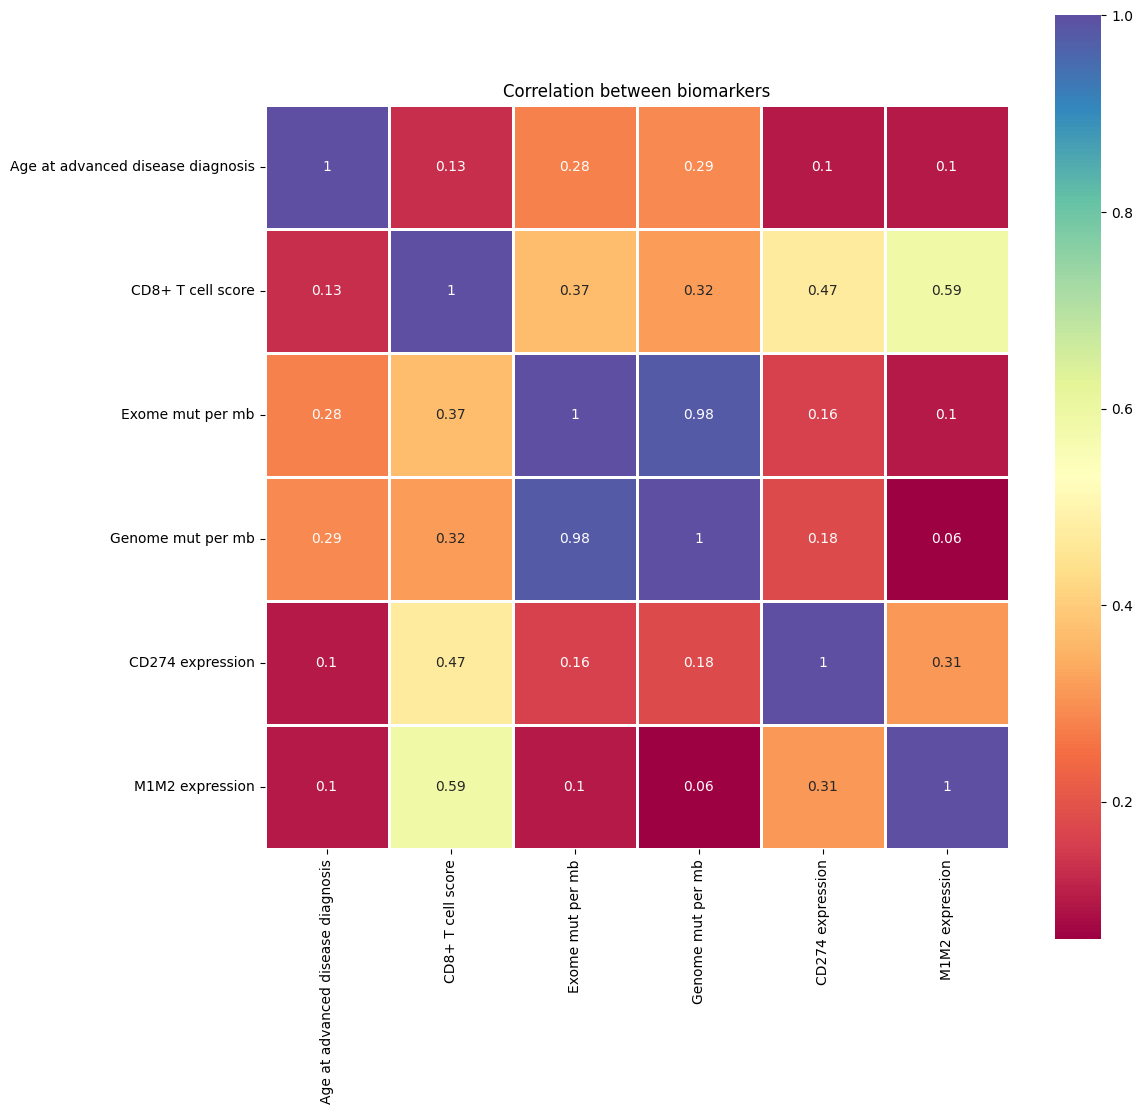

In [94]:
df_corr = df.loc[:,["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]]

# Correlations :
correlation = np.round(df_corr.corr(),2)

# Heatmap plot
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(correlation,linewidths=1, square=True, annot=True,cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title("Correlation between biomarkers")
plt.savefig("heatmap-correlation-biomarkers.png")

#### ii. Feature importance with Random Forest Classifier
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html 
The random forests are useful to estimate the importance of each feature in the classification task. Indeed, with the impurety measure, we can estimate the discriminative property of a given feature. Let's test ! 

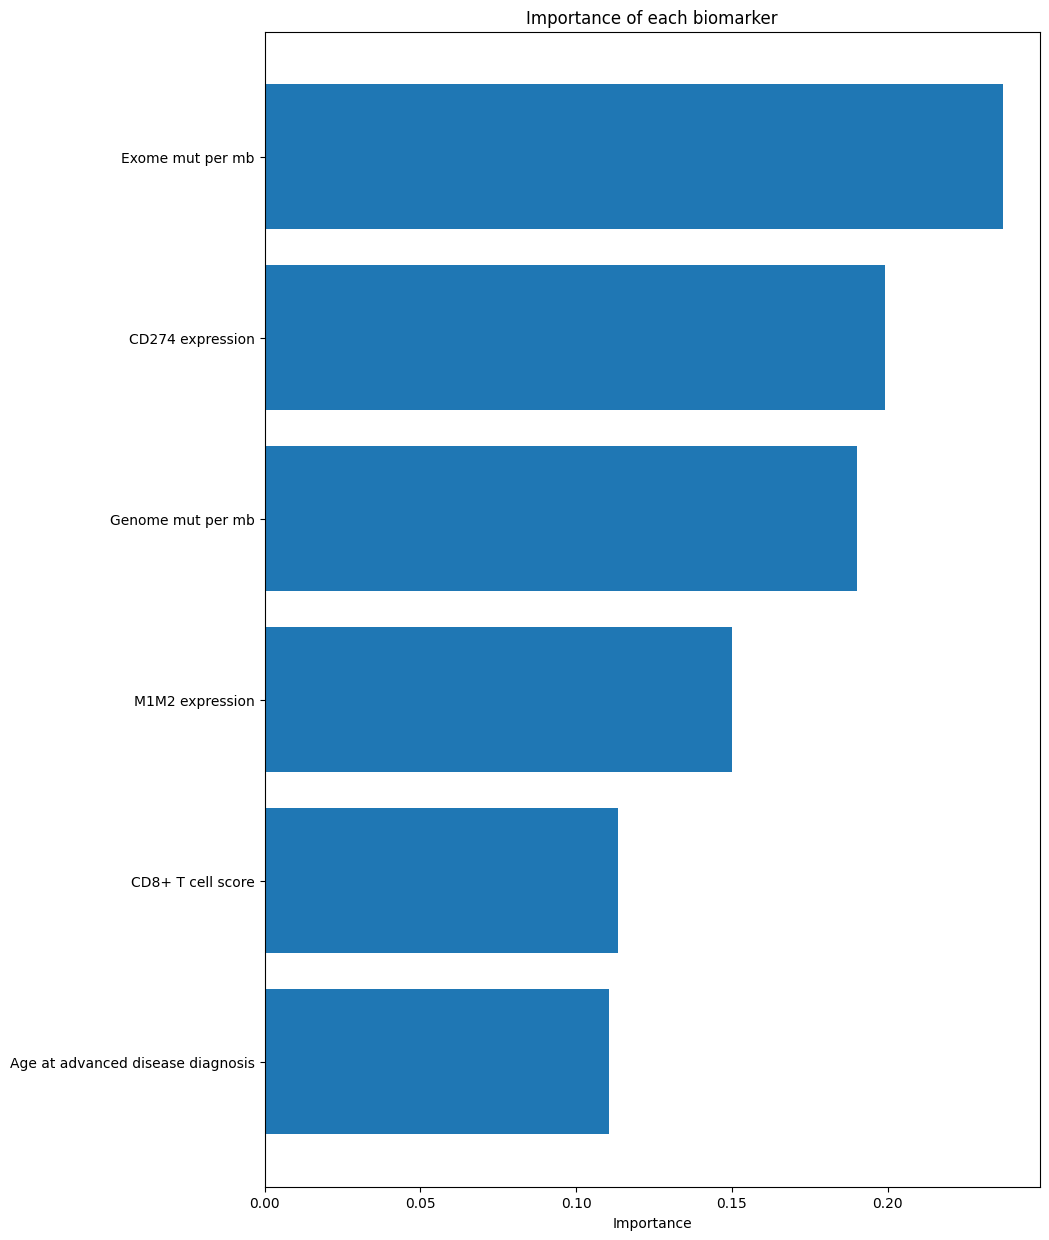

In [95]:
# Fitting the RF classifier and compute the feature importances
rf_clf = RandomForestClassifier()
X_rf = df.loc[:,["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]]
y_rf = df["Clinical benefit"].to_numpy()
rf_clf.fit(X_rf, y_rf)
feat_importance = rf_clf.feature_importances_

# Sort the result
indices_feat_importance = feat_importance.argsort()
feat_importance_sorted = feat_importance[indices_feat_importance]
biomarkers_per_importance = np.array(X_rf.columns)[indices_feat_importance]

# Plot the result
plt.figure(figsize=(10,15))
plt.barh(biomarkers_per_importance,feat_importance_sorted)
plt.xlabel("Importance")
plt.title("Importance of each biomarker")
plt.savefig("feature-importance.png")


So, we want to keep : 
- Exome mut per mb
- Genome mut per mb
- M1M2 expression
- CD8+ T cell score
- CD274 expression
- SBS5 signature
- SBS7c signature

### Normalization

In [96]:
# Normalization
selected_columns = ["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]
X = df.loc[:,selected_columns].to_numpy()
X = StandardScaler().fit_transform(X)

## 2. Compare high risk patients and low risk patients

### a. Find risk classes
With the ```CoxModel``` class implementing a Cox Regression, we can determine the risk class for each sample : high (class 1) or low (class 0). Because we have few data, we use a **leave one out cross validation**, which consists in fitting the model with all the dataset except 1 sample, then we predict the risk class for the test sample.

In [97]:
# Preprocessing data (drop nan values)
# df = df.dropna()
#selected_columns = ["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression","SBS2","SBS4","SBS18","SBS5","SBS6","SBS7a","SBS7b","SBS7c","SBS13","SBS26","SBS44"]
# selected_columns = ["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression","SBS5","SBS7c"]
# X = df.loc[:,selected_columns].to_numpy()
y_ttp = np.array(list((df[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])
y_os = np.array(list((df[['Alive_0','Overall survival (days)']].itertuples(index=False, name=None))),dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

In [98]:
# Finding the risk classes - TTP
risk_classes_ttp, risk_scores_ttp = coxmodel.leave_one_out_cross_validation(X,y_ttp)
print("TTP :")
print(risk_classes_ttp)
print(risk_scores_ttp)

# Finding the risk classes - OS
print("\n OS :")
risk_classes_os, risk_scores_os = coxmodel.leave_one_out_cross_validation(X,y_os)
print(risk_classes_os)
print(risk_scores_os)

TTP :
[0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
[-0.76423884  0.40138244  0.2066007   0.32333207  0.31676585 -0.30123116
  0.80631442 -0.81601157  0.59965026  5.57624525 -0.3766825   0.46203021
  0.485102    0.31329173 -0.3680706   0.65387869 -0.2871272  -0.86279722
  0.62419845  0.59536857  0.35711416  0.11706421 -0.27129139 -0.41409462
  0.46715209  0.01603007  0.5651377   0.15441891  0.59829604  0.54143408
  0.37557779  0.36831988  0.70383043  0.48687751  0.47010991 -0.31171948
 -0.39497667 -0.79964893  0.37654955 -0.35122746  0.23579942  0.34921384
  0.45302547  0.35533065 -0.22651444 -0.49809989 -0.59237841  0.39439371
 -1.6776547  -3.63456176 -0.54912182  0.35094574  0.39776296  0.46939008
  0.35623256  0.52257773  0.094021    0.44813397  0.48111848  0.08161682
  0.44799437 

### b. Compute concordance index
In this context, the concordance index measures the proportion of patients comparable pairs in which the risk score and the surviving time are concordant.

In [99]:
# TTP : 
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
c_index_ttp = coxmodel.get_c_index(status_ttp, time_ttp, risk_scores_ttp)
print(f"C index (TTP) : {c_index_ttp}")

# OS :
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()
c_index_os = coxmodel.get_c_index(status_os, time_os, risk_scores_os)
print(f"C index (OS) : {c_index_os}")

C index (TTP) : 0.58
C index (OS) : 0.56


### c. Compute p value of the log rank test
The log rank test compares 2 survival curves. If the p value is low (under 5%), the 2 curves are different. Otherwise, the 2 curves are pretty similar. We make this test for the low risk (class 0) and high risk curves (class 1).

In [100]:
# TTP :
p_value_ttp = coxmodel.log_rank_test(status_ttp.astype(int), time_ttp, risk_classes_ttp)
print(f"p value (TTP) : {p_value_ttp}")

# OS :
p_value_os = coxmodel.log_rank_test(status_os.astype(int), time_os, risk_classes_os)
print(f"p value (OS) : {p_value_os}")

p value (TTP) : 0.04
p value (OS) : 0.19


### d. Vizualize survival curves for each class

In [101]:
# TTP :
print("TTP : ")
# Low risk class
status_low_ttp, time_low_ttp = status_ttp[np.where(risk_classes_ttp==0)], time_ttp[np.where(risk_classes_ttp==0)]
time_axis_low_ttp, prob_axis_low_ttp = coxmodel.kaplan_meier_estimation(status_low_ttp, time_low_ttp)
# High risk class
status_high_ttp, time_high_ttp = status_ttp[np.where(risk_classes_ttp==1)], time_ttp[np.where(risk_classes_ttp==1)]
time_axis_high_ttp, prob_axis_high_ttp = coxmodel.kaplan_meier_estimation(status_high_ttp, time_high_ttp)
print(f"n_samples low risk : {status_low_ttp.shape[0]}")
print(f"n_samples high risk : {status_high_ttp.shape[0]}")

# OS :
print("\n OS : ")
# Low risk class
status_low_os, time_low_os = status_os[np.where(risk_classes_os==0)], time_os[np.where(risk_classes_os==0)]
time_axis_low_os, prob_axis_low_os = coxmodel.kaplan_meier_estimation(status_low_os, time_low_os)
# High risk class
status_high_os, time_high_os = status_os[np.where(risk_classes_os==1)], time_os[np.where(risk_classes_os==1)]
time_axis_high_os, prob_axis_high_os = coxmodel.kaplan_meier_estimation(status_high_os, time_high_os)
print(f"n_samples low risk : {status_low_os.shape[0]}")
print(f"n_samples high risk : {status_high_os.shape[0]}")

TTP : 
n_samples low risk : 38
n_samples high risk : 44

 OS : 
n_samples low risk : 40
n_samples high risk : 42


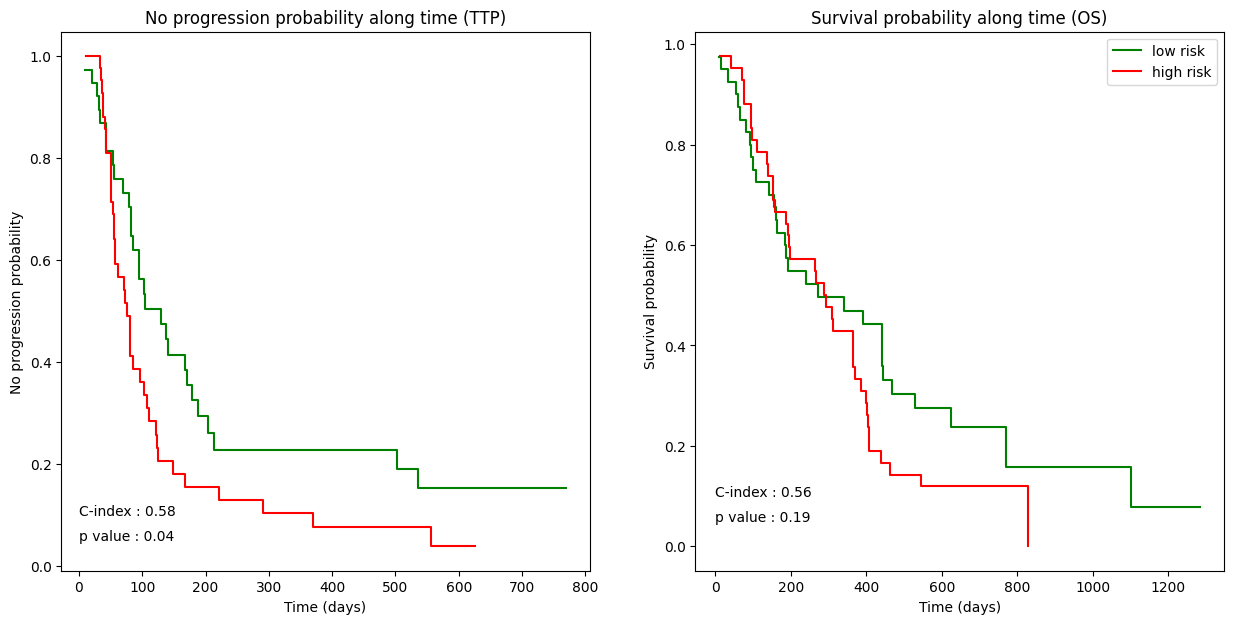

In [102]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].step(time_axis_low_ttp, prob_axis_low_ttp, where='post',color='green',label='low risk')
ax[0].step(time_axis_high_ttp, prob_axis_high_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('No progression probability')
ax[0].set_title('No progression probability along time (TTP)')
ax[0].text(0,0.1,f'C-index : {c_index_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_ttp}')

ax[1].step(time_axis_low_os, prob_axis_low_os, where='post',color='green',label='low risk')
ax[1].step(time_axis_high_os, prob_axis_high_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Survival probability')
ax[1].set_title('Survival probability along time (OS)')
ax[1].text(0,0.1,f'C-index : {c_index_os}')
ax[1].text(0,0.05,f'p value : {p_value_os}')

plt.legend()
plt.savefig('km-survival-curve.png')